In [1]:
import os
import csv
import torch
import time as timer
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F

from utils import make_folder
from forcing_functions import get_function
from siren import EarlyStopper, get_4_dof_model, latin_hypercube_1D, system_ode_loss
from finite_element_code import set_up_4_dof, get_mck, integrate_rk4

### Set Up PyTorch

In [2]:
# Set random seed
torch.manual_seed(123)

# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"

### Set Up FE Model

In [3]:
# Get model parameters
x, y, E, nu, rho, a0, a1, fdim, free_indices, ndim, _ = set_up_4_dof()

# Construct mass, damping, and stiffness matrices
m, c, k = get_mck(x, y, E, nu, rho, a0, a1, free_indices)

# Define forcing functions
functions = ("gaussian", "sine", "chirp")

# Define datasets - each entry is a list of nodes where data will be given (in addition to ICs)
given_data = [
    [0, 2, 3],
    [2, 3],
    [3],
    []
]

### Set Up PINN

In [4]:
t0 = 0
t1 = 2.9
ntc = 290
ntp = int((t1 - t0) * 500)
tc = torch.linspace(t0, t1, ntc, device="cuda")
tp = latin_hypercube_1D(t0, t1, ntp, device="cuda")

alpha = 1e-14  # physics loss weight

learning_rate = 1e-3
max_iterations = 60_000
iterations_til_summary = 1000  # print summary every 1000 iterations

### Test Different Cases

NOW SOLVING FUNCTION: gaussian
GIVEN NODES: [0, 2, 3]
torch.cuda.memory_allocated() -> 8879104
Iteration 0: L_c = 0.20056 -- L_p = 7.6451e+13


KeyboardInterrupt: 

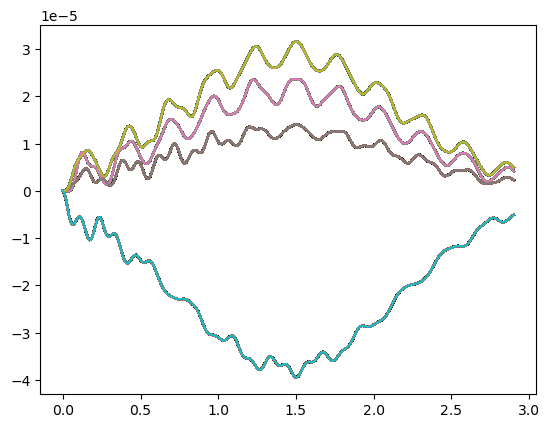

In [6]:
for forcing_function in functions:
    # Get forcing function
    ffun = get_function(
        name=forcing_function,
        t0=t0,
        t1=t1,
        amplitude=-1e3,
        total_dimensions=ndim,
        force_dimension=fdim,
    )

    # Integrate to get time-histories
    displacements, velocities = integrate_rk4(m, c, k, ffun, tc)

    # Make folder to store data
    force_folder_name = make_folder(name=os.path.join("outputs", forcing_function))

    for node_list in given_data:
        print("NOW SOLVING FUNCTION:", forcing_function)
        print("GIVEN NODES:", node_list)
        print("torch.cuda.memory_allocated() ->", torch.cuda.memory_allocated())

        # Get start time
        start = timer.time()

        # Make folder to store data
        node_folder_name = make_folder(
            os.path.join(force_folder_name, "%d_nodes_given" % len(node_list))
        )

        # Get maximum displacement - used for normalizing outputs. Only consider amplitude of given nodes.
        if len(node_list) > 0:
            max_displacement = displacements[node_list].abs().max()
        else:  
            max_displacement = torch.as_tensor(2e-5, device=device)  # estimate

        # Create PINN
        model = get_4_dof_model()

        # Instantiate optimizer
        optimizer = torch.optim.Adam(
            model.parameters(),
            lr=learning_rate,
        )

        # Perform training
        csv_filename = os.path.join(node_folder_name, "loss_history.csv")
        model_save_file = os.path.join(node_folder_name, "model.pt")
        plot_save_file = os.path.join(node_folder_name, "result.png")

        with open(csv_filename, "w") as csvfile:
            writer = csv.writer(csvfile)
            writer.writerow(
                ["Epoch", "Collocation Loss", "Physics Loss", "Total Loss", "Alpha"]
            )

            for step in range(max_iterations):
                optimizer.zero_grad()

                # Shuffle training data - helps a lot with convergence
                shuffle_idx_c = torch.randperm(ntc)
                shuffle_idx_p = torch.randperm(ntp)

                # Enforce Collocation
                model_output, _ = model(tc[shuffle_idx_c].reshape(-1, 1))
                target = displacements.T[shuffle_idx_c] / max_displacement

                collocation_loss = F.mse_loss(
                    model_output[:, node_list], target[:, node_list]
                ) + F.mse_loss(
                    model_output[0, :], 0 * model_output[0, :]
                )

                # Enforce Physics
                model_output_phys, coords = model(tp[shuffle_idx_p].reshape(-1, 1))
                physical_loss = system_ode_loss(
                    coords,
                    model_output_phys,
                    ffun(tp[shuffle_idx_p]),
                    m,
                    c,
                    k,
                    max_displacement,
                )

                # Total loss
                loss = collocation_loss + alpha * physical_loss

                # Print out an update, save model, + log to file
                if step % iterations_til_summary == 0:
                    print(
                        "Iteration %d: L_c = %.5g -- L_p = %.5g"
                        % (step, collocation_loss, physical_loss)
                    )
                    writer.writerow(
                        [step, collocation_loss.item(), physical_loss.item(), loss.item(), alpha]
                    )
                    torch.save(model.state_dict(), model_save_file)

                # Backpropagate
                loss.backward()

                # Update model parameters
                optimizer.step()

        # Training finished.
        end = timer.time()
        print("Training completed in %.5g seconds." % (end - start))

        # Make plot of the results
        u_pred, _ = model(tc.reshape(-1, 1))

        fig, ax = plt.subplots(ndim // 2, 2, sharex=True, sharey=True, figsize=(10, 5))

        for i in range(ndim // 2):
            # Plot solution
            ax[i, 0].plot(
                tc.cpu(),
                displacements[2 * i].cpu(),
                color="gray",
                alpha=0.4,
                label="Solution",
            )
            ax[i, 1].plot(
                tc.cpu(),
                displacements[2 * i + 1].cpu(),
                color="gray",
                alpha=0.4,
                label="Solution",
            )

            # Plot model prediction
            ax[i, 0].plot(
                tc.cpu(),
                u_pred.detach()[:, 2 * i].cpu() * max_displacement.cpu(),
                color="green",
                label="Prediction",
            )
            ax[i, 1].plot(
                tc.cpu(),
                u_pred.detach()[:, 2 * i + 1].cpu() * max_displacement.cpu(),
                color="green",
                label="Prediction",
            )

            # Format plots
            ax[i, 0].set_ylim(displacements.cpu().min(), displacements.cpu().max())
            ax[i, 1].set_ylim(displacements.cpu().min(), displacements.cpu().max())
            ax[i, 0].set_ylabel("Node %d" % (2 + i))

            if i == 0:
                ax[i, 0].set_title("X-Displacement (m)")
                ax[i, 1].set_title("Y-Displacement (m)")

            if 2*i in node_list:
                # Plot given data
                ax[i, 0].plot(
                    tc.cpu(),
                    displacements[2 * i].cpu(),
                    color="orange",
                    label="Data",
                    marker=".",
                    markersize=1,
                    linestyle="None",
                )
            
            if (2*i + 1) in node_list:
                ax[i, 1].plot(
                    tc.cpu(),
                    displacements[2 * i + 1].cpu(),
                    color="orange",
                    label="Data",
                    marker=".",
                    markersize=1,
                    linestyle="None",
                )

            # Legend
            if i == 0:
                ax[i, 1].legend(loc="upper center", ncols=1, bbox_to_anchor=(1.2, 1))

        plt.savefig(plot_save_file, bbox_inches="tight")
        plt.close()

        # Delete all unneeded variables
        del (
            model,
            fig,
            ax,
            u_pred,
            start,
            end,
            optimizer,
            loss,
            physical_loss,
            collocation_loss,
            target,
            model_output,
            shuffle_idx_c,
            shuffle_idx_p,
            writer,
        )
        
        torch.cuda.empty_cache()